## Notebook to illustrate how the probablistic jerk finder works.

#### Here is an assumed underlying piecewise linear time dependence with a change in slope at t=50:

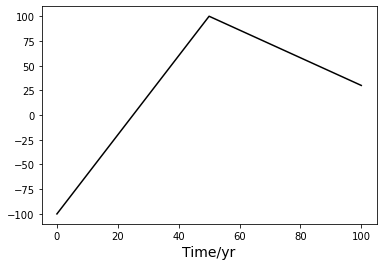

In [1]:
import matplotlib.pyplot as plt
import numpy as np
time_for_plotting = np.linspace(0,100,100,endpoint=True)
plt.figure()
plt.plot([0,50,100],[-100,100,30],'k');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_raw_signal.pdf',bbox_inches='tight')

#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

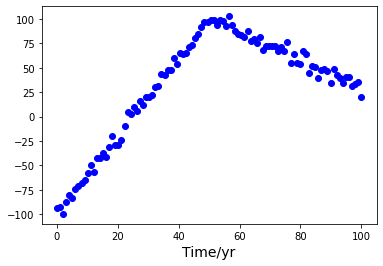

In [2]:
plt.figure()
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(0,100,NUM_DATA,dtype=float)
delta_Y = 5 * np.ones(NUM_DATA)
Y = np.interp(TIMES,[0,50,100],[-100,100,30]) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_noised_signal.pdf',bbox_inches='tight')

In [4]:
import os
import sys
sys.path.append( os.path.abspath('..') )
sys.path.append( os.path.abspath('.') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200
discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 100
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in
time_intervals_nbins = 101  #collect change point histogram over 101 bins for the 100 time units, f
#[-0.5,0.5], ....[99.5, 100.5]
time_intervals_edges = np.linspace(TIMES_MIN-0.5, TIMES_MAX+0.5, time_intervals_nbins+1, endpoint = True)

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist = np.zeros( time_intervals_nbins,dtype=int )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)
delta_slope = np.zeros( time_intervals_nbins,dtype=int )

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[13.96010017  7.78571749  1.58093047  1.58311975]


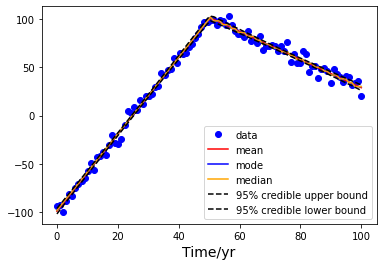

In [5]:
plt.figure()
plt.plot(TIMES,Y,'bo', label='data')
plt.plot(time_for_plotting,AV,'r', label='mean')
plt.plot(time_for_plotting,MODE, 'b',  label='mode')
plt.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
plt.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
plt.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
plt.legend(loc='lower right')
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example1_posterior.pdf',bbox_inches='tight')

#### Histogram of vertex probability with original time series. The vertical scale indicates the probability that an internal vertex is in each (1 time unit) bin:

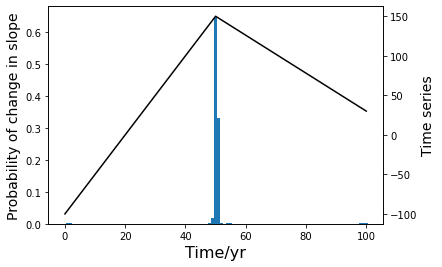

In [6]:
# Binning in code:
# bins are 0-1, 1-2, 2-3, 3-4, etc. with left edges at 0,1,2,3,4,...
# 
plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges, CP_hist/fac, align='edge', width = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,150,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Probability of change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_timing.pdf',bbox_inches='tight')

In [7]:
from scipy.signal import find_peaks
peaks,_ = find_peaks(CP_hist/fac, height=0.1)
print('Most probable change in slope is between {0:f} and {1:f}'.format
      (left_edges[peaks][0], left_edges[peaks+1][0]))

Most probable change in slope is between 49.500000 and 50.500000


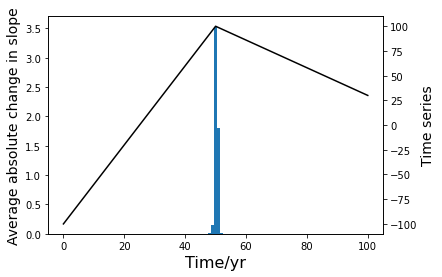

In [8]:
# Binning in code:
# bins are 0-1, 1-2, 2-3, 3-4, etc. with left edges at 0,1,2,3,4,...
# 
# exclude boundary effects:

plt.figure()
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax = plt.gca()
plt.bar(left_edges[5:-5], delta_slope[5:-5], align='edge', width = time_intervals_edges[1] - time_intervals_edges[0])
ax2 = ax.twinx()
plt.plot([0,50,100],[-100,100,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Average absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example1_jerk_delta_slope.pdf',bbox_inches='tight')

In [46]:
# Change in slope from original data set

In [47]:
delta = 1e-6
Y0 = np.interp(TIMES-delta,[0,50,100],[-100,100,30])
Y1 = np.interp(TIMES,[0,50,100],[-100,100,30])
Y2 = np.interp(TIMES+delta,[0,50,100],[-100,100,30])
slope2= (Y2-Y1)/delta
slope1 = (Y1-Y0)/delta

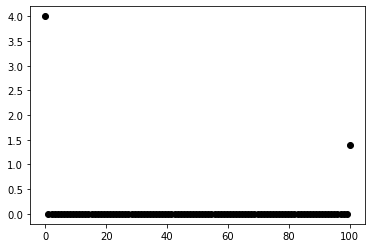

In [48]:
plt.figure()
plt.plot(TIMES, abs(slope2-slope1),'ko')


In [49]:
#[0,50,100],[-100,100,30]

In [50]:
print('Change in slope is ', -70/50 - 200/50)

Change in slope is  -5.4


In [51]:
delta_slope.sum(), delta_slope.max()

(5.857491294508608, 3.5400936359145505)

In [ ]:
(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
